## To-Do
- For `generate_randomids()`, should we allow giving a molecule density parameter to populate based on a target density? If so, what form of density should we use?
    - KMCsim_v5 uses:  $\phi = Na_{\text{mol}}\pi/(2a_{\text{box}}^{2})$
    - https://torquatocpanel.deptcpanel.princeton.edu/wp-content/uploads/2018/07/paper-404.pdf:  $\phi = Nd_{\text{mol}}a_{\text{mol}}\pi/(2a_{\text{box}}^{2})$
    - https://pubs.rsc.org/en/content/getauthorversionpdf/c9sm00333a:  $\phi = Na_{\text{mol}}\pi/(4a_{\text{box}}^{2})$

## References

- Main reference: [A Practical Guide to Surface Kinetic Monte Carlo Simulations (2019)](https://www.frontiersin.org/articles/10.3389/fchem.2019.00202/full)
- [Accurate determination of the translational correlation function of two-dimensional solids (2019)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.100.062606)
- [Frank's constant in the hexatic phase (P. Keim, G. Maret, and H.H. von Grunberg, 2018)](https://arxiv.org/pdf/cond-mat/0610332.pdf)
- [A kinetic Monte Carlo approach to diffusion-controlled thermal desorption spectroscopy (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5468722/)
    - "As the time step depends on the temperature through the rate constants and the temperature changes with time, the time scale within the simulations must be comparable to experimental time scales to obtain meaningful results. Care must be taken if the starting temperature of the KMC simulation is too low as this would result in artificially large time steps and correspondingly large jumps in the temperature, and thus many processes that should have already occurred at lower T would be skipped... ... It is thus necessary either to carefully choose a suitable starting temperature, which is only possible if the process rates are homogeneous, or to limit the time step and only perform a KMC step if: $\Delta t(T_{1}) < t_{0} + \Delta t (T_{1} + \beta \Delta t_{0})$."
    - *This tells us that we need to carefully limit the maximum temperature change between KMC steps to avoid the simulation potentially skipping important processes*.
- [Kinetic Monte Carlo - slide deck (2006)](https://www.mv.helsinki.fi/home/knordlun/mc/mc8nc.pdf)
    - "Moreover, if we use Eq. 1 to derive the event probability in our simulations, we get the added advantage that we can do simulations at any temperature realistically, even if the temperature keeps changing during the modeling."
    - *This tells us that we don't have to equilibriate each time we change temperature, we just have to carefully limit the maximum temperature change.*
- [Bond-Orientational Order in Condensed Matter Systems (J.D. Brock, K.J. Strandburg, et al., 1992)](https://link.springer.com/book/10.1007/978-1-4612-2812-7)

## Code

In [1]:
import cupy as cp
import freud
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from numba.core.errors import NumbaPerformanceWarning
import numpy as np
import os
import scipy as sp
import sys
import warnings
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
os.environ['CUPY_ACCELERATORS'] = 'cub,cutensor'

sys.path.append('..')
from src import *

%matplotlib ipympl

# To generate requirements.txt: pip freeze > requirements.txt
# To generate environment.yml: conda env export --no-build > environment.yml
# To update environment.yml: conda env update --prefix $KMCENV --file environment.yml --prune
# To create from environment.yml: conda env create --prefix $KMCENV --file environment.yml --force

Since the lattice constant for the triangular lattice potential is much larger than that of the graphene lattice, we need to determine the ideal box width that will satisfy periodic boundary conditions for the triangular lattice potential.

In [2]:
# ideal_boxwidths(tri_lc=3.936, kag_lc=0.246, target_width=300, show_topn=5) 

Generated 800 molecule position indices in 1 attempts.
System box dimensions (nm): (102.3360, 102.2603)
Number of Kagome unit cells (columns, rows): (416, 240)
Number of total Kagome lattice sites: 599040
Packing fraction density: 0.050145843403263016
Global bond orientational order: 0.434190034866333


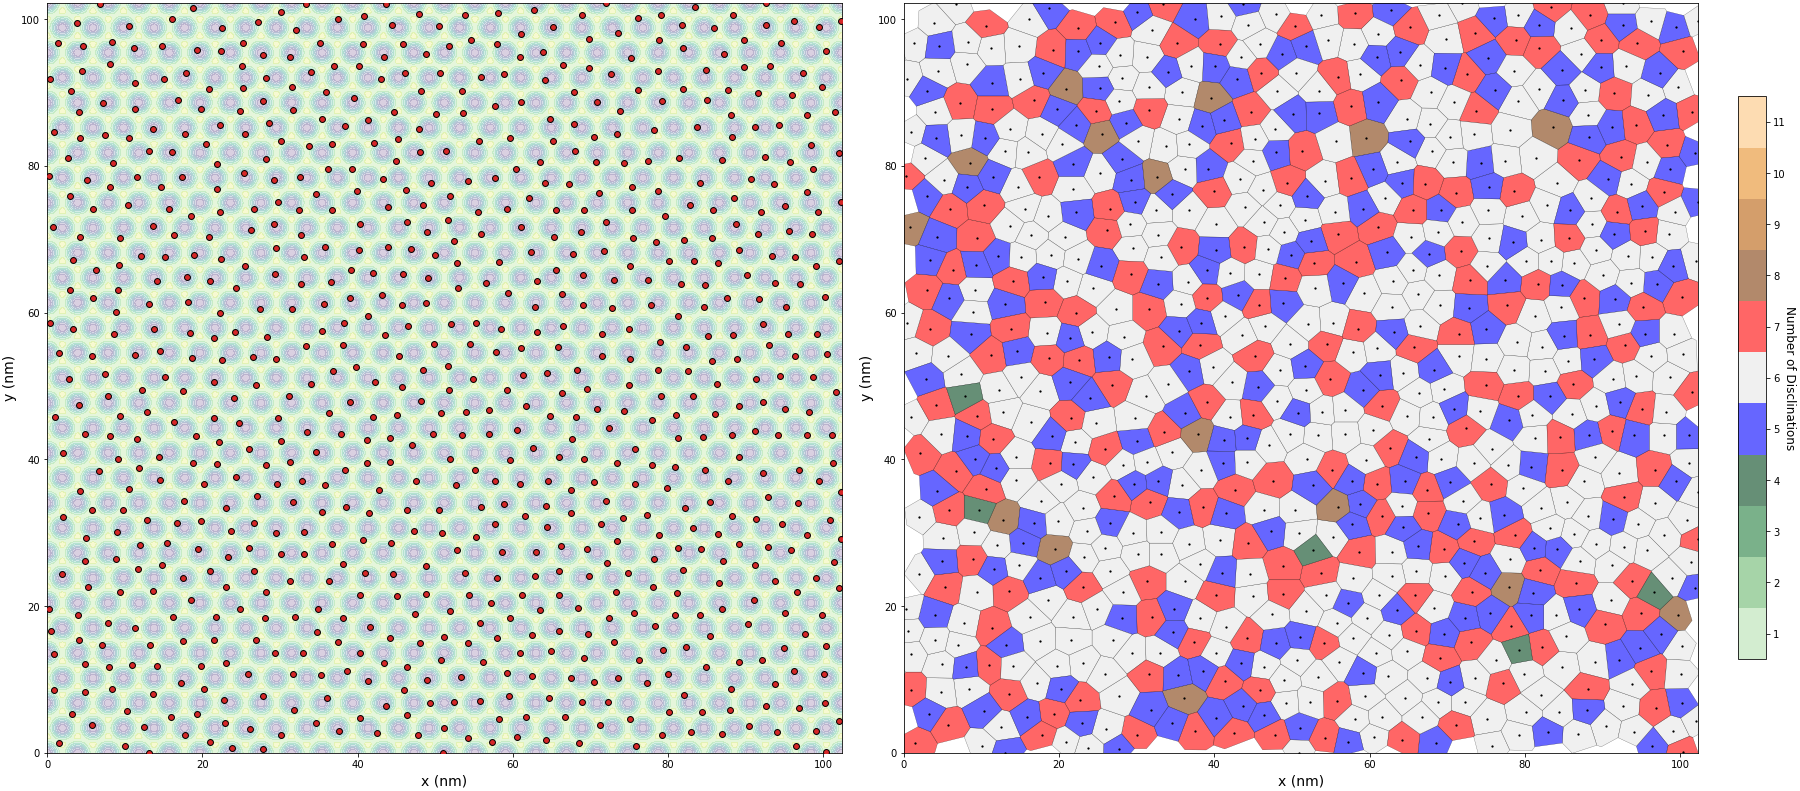

In [3]:
boxwidth = 102.336  # 102.336
n_molecules = 800  # 400, 800, 1200, 1600, 2000
threshold = 12  # 17, 12, 9, 8, 7

# Initialize the simulation lattice
kagome = KagomeLattice(boxwidth=boxwidth)
# Get array of all lattice sites xy-coordinates
lxy = kagome.get_latticesites()
# Get array of all nearest neighbor indices for each lattice site
lnnids = kagome.get_sitennids(cp.arange(lxy.shape[0], dtype=kagome._idtype))
# Get array of random molecule position indices
if n_molecules > 0: mids = kagome.generate_randomids(n_molecules=n_molecules, sites=lxy, n_attempts=1000, threshold=threshold)
# Define the lattice energy surface (here, a triangular lattice potential)
tle = TriangularLatticeEnergies(lattice_constant=3.936, amplitude=39.8)

# Compute packing fraction density (real experiment value 0.03730798355770559)
xdim, ydim = kagome.boxsize
rho = (n_molecules*np.pi*0.48*0.87) / (2*xdim*ydim)
print(f"System box dimensions (nm): ({kagome.boxsize[0]:.4f}, {kagome.boxsize[1]:.4f})")
print(f"Number of Kagome unit cells (columns, rows): {kagome.n_unitcells}")
print(f"Number of total Kagome lattice sites: {kagome._n_totalsites}")
print(f"Packing fraction density: {rho}")


fig, axs = plt.subplots(1, 2, figsize=(25, 11*figsize_yscale(kagome)), layout='constrained', dpi=72)
fig.canvas.resizable = False
# Plot the lattice energy surface
axs[0] = plot_latticeenergies(axs[0], tle, kagome.boxsize, nsamples=1000, cmap='viridis', alpha=0.75, zorder=1)
if boxwidth <= 10:
    # Plot the graphene lattice bonds
    axs[0] = plot_graphenebonds(axs[0], kagome, colors='b', lw=0.5, ls='--', alpha=0.25, zorder=2)
    # Plot the Kagome lattice sites
    axs[0] = plot_kagomesites(axs[0], kagome, s=18, c='k', ec='k', alpha=0.3, zorder=3)
if n_molecules > 0:
    # Plot the molecules
    axs[0] = plot_molecules(axs[0], lxy[lnnids[mids]].get(), show_nn=False, s=35, lw=1.0, mc='tab:red')
# Plot the hexagonal order parameter
fig, axs[1] = plot_disclinations(fig, axs[1], kagome, lxy[mids].get())

for i in range(2):
    axs[i].set(xlim=kagome.xlim, ylim=kagome.ylim)
    axs[i].set_xlabel('x (nm)', fontsize=14)
    axs[i].set_ylabel('y (nm)', fontsize=14)
plt.show()

- How should we define how the steps should be recorded and how to tell the simulation to end?

In [4]:
duration = 1*60  # In seconds
nsteps = None
energy_params = {
    'lattice':'none',
    'lattice_params':{'lattice_constant':3.936, 'amplitude':39.8, 'angle':0., 'shift':[0., 0.]},
    'interaction':'total_impurity',
    'interaction_params':{'Zval':1.0, 'epsr':4.22}
}
temperature_params = {'temp_initial':30, 'temp_final':8.5, 'method':'linear'}

simdata = simulate(kagome, energy_params, temperature_params, n_molecules, duration, threshold, frames_per_kelvin=60, nwarmupsteps=50000)

Setting up the simulation...
Generated 800 molecule position indices in 1 attempts.
Starting simulation warm-up steps at 30.00 K...
Warm-up step 50000 / 50000 completed.
Warm-up steps completed in 145.555 seconds on CPU and 145553.172 seconds on GPU.

Starting KMC steps...


In [ ]:
# Save the simulation data
import pickle

with open('../data/simdata.pkl', 'wb') as f:
    pickle.dump(simdata, f)

# with open('../data/simdata.pkl', 'rb') as f:
#     simdata = pickle.load(f)

In [ ]:
# timevals = cp.linspace(1e-7, 1, 10000)
# tempfunc, _, _ = temperature_function(duration, **temperature_params)
# fig, ax = plt.subplots(figsize=(10, 8), layout='constrained', dpi=72)
# ax.plot(timevals.get(), tempfunc(timevals).get(), lw=2.0, c='k')
# ax.set_xlim(0, 1e-2)
# plt.show()

In [ ]:
# duration = 1*60  # In seconds
# nsteps = None
# energy_params = {
#     'lattice':'none',
#     'lattice_params':{'lattice_constant':3.936, 'amplitude':39.8, 'angle':0., 'shift':[0., 0.]},
#     'interaction':'total_impurity',
#     'interaction_params':{'Zval':1.0, 'epsr':4.22}
# }
# temperature_params = {'temp_initial':30, 'temp_final':8.5, 'method':'linear'}

# simdata = simulate(kagome, energy_params, temperature_params, n_molecules, duration, threshold, frames_per_kelvin=60, nwarmupsteps=150000)

# fig = plt.figure(figsize=(24, 14), layout='constrained', dpi=72)
# gs = GridSpec(4, 3, figure=fig)
# axs = [
#     fig.add_subplot(gs[0, 0]),
#     fig.add_subplot(gs[1, 0]),
#     fig.add_subplot(gs[2, 0]),
#     fig.add_subplot(gs[3, 0]),
#     fig.add_subplot(gs[:, 1:]),
# ]

# fig.canvas.resizable = False
# line1, = axs[0].plot([], [])
# line2, = axs[1].plot([], [])
# line3, = axs[2].plot([], [])
# line4, = axs[3].plot([], [])
# line5, = axs[4].plot([], [], 'o', color='r', ms=5, mec='k')
# axs[0].set_title('Time (s)')
# axs[1].set_yscale('log')
# axs[1].set_title('Total cumulative rate (Hz)')
# axs[2].set_yscale('log')
# axs[2].set_title('Total energy (Hartree energy units)')
# axs[3].set_xscale('log')
# # axs[3].set_ylim(0.3, 0.5)
# axs[3].set_title('Global psi6 parameter')
# axs[3].set_xlabel('Simulation step number')
# axs[4].set(xlim=kagome.xlim, ylim=kagome.ylim)
# axs[4].set_xlabel('x (nm)', fontsize=14)
# axs[4].set_ylabel('y (nm)', fontsize=14)
# axs[4].grid(alpha=0.5, linestyle='--')

# def update_plot(data):
#     stepnum, times, rates, energies = data #, gboops, rxy
#     axs[0].set_title(f'Total time: {np.sum(times):.3g} s | Avg time interval: {np.mean(times):.3g} s')
#     line1.set_data(stepnum, times)
#     line2.set_data(stepnum, rates)
#     line3.set_data(stepnum, energies)
#     # line4.set_data(stepnum, gboops)
#     # line5.set_data(rxy[:,0], rxy[:,1])
#     for i in range(4):
#         axs[i].relim()
#         axs[i].autoscale_view()
#     return line1, line2, line3#, line4, line5

# ani = animation.FuncAnimation(fig, update_plot, frames=simulate(kagome, energy_params, temperature_params, n_molecules, duration, threshold, frames_per_kelvin=60, nwarmupsteps=300000), blit=True, interval=33, repeat=False)
# plt.show()

In [ ]:
# # Verify that the nearest neighbor distances are all correct
# lnnxy = lxy[lnnids]
# lnndists = cp.abs(lnnxy[:,1:,:] - lnnxy[:,0,None,:])
# lnndists = cp.minimum(lnndists, kagome._dims-lnndists, out=lnndists)
# lnndists = cp.linalg.norm(lnndists, axis=-1).get()
# print(lnndists.shape)
# for i, d in enumerate(lnndists):
#     if not np.all(np.isclose(d, 0.246)):
#         print(i, d)

Let's compare with experimental data

In [ ]:
# e8_boxwidth = 200  # nm
# e8_pixelwidth = 512  # pixels
# e8_lpp = e8_boxwidth / e8_pixelwidth  # unit length in nm / pixels
# e8_num_molecules = 2275  # number of molecules
# e8_rho = e8_num_molecules / (e8_boxwidth**2)  # molecule density
# e8_eta = (e8_num_molecules*0.246*0.246*0.5) / (e8_boxwidth**2)  # packing fraction
# e8_pf = (e8_num_molecules*np.pi*0.48*0.87) / (2*(e8_boxwidth**2))   # KMCsim packing fraction (where did this come from?)
# print(e8_rho, e8_eta, e8_pf)

# filename = '/data/e8_217.csv'
# df = pd.read_csv(os.getcwd()+filename, header=0, names=['x','y']) * lpp
# coords = df.to_numpy()